# **FICO Analytic Challenge © Fair Isaac 2024**
# Week 9: Model Building Revisit

In the previous weeks you have successfully built an end-to-end model! That is a big achievement. Congratulations! But, what’s next?  



In the first stage of a model development cycle, modelers build an end-to-end baseline model (like what you have done in all previous weeks), so that in the worst-case scenario they still have a robust model to deliver. But modelers do not simply stop there. Usually, they go through several iterations to improve their model on top of the baseline. For example, they introduce new innovative features, revisit feature selections, double check overfitting, optimize the hyper-parameters of the model, and so on. There are so many things to do. We will cover part of them this week so that you have some ideas about how to further improve your model.

In [ ]:
import os
import sys
import time
import datetime
import pandas as pd
import numpy as np
from pickle import dump, load
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from google.colab import drive
import copy

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
lauc_threshold = 0.02

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## New Variables

In this iteration, you may have come up with some new and innovative variables. With those new variables, one can retrain the model in a similar way to week 6. That means loading in the new variables, combine with the old variables in the baseline model, repeat processes like scaling, train the neural network model, and monitor key metrics like auc and lauc for both training set and validation set to see if with the new variables our model is improved.

Here, we just load in the feature dataframe with new variables for later use.

In [ ]:
# Checking GPU compatibility
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
root_dir = '/content/drive/MyDrive/FICO Analytic Challenge/'
sys.path.append(root_dir +'Week 09')

# Folder's name that's holding data of interest
data = 'Data'

# Model name; this will be used to distinguish model's output files
model='NNet'

In [ ]:
# dataset file prefix
trainFile = ['train']
testFile = ['test_A']
# testFile = ['test_B']

# CSV filename and where outputs will be saved
trainsaveCSV = os.path.join(root_dir + data, 'score.' + model + '.' + trainFile[0] + "_with_advanced_features.csv")
testsaveCSV = os.path.join(root_dir + data, 'score.' + model + '.' + testFile[0] + "_with_advanced_features.csv")
print("Path to Train Output file and filename: {}".format(trainsaveCSV))
print("Path to Test Output file and filename: {}".format(testsaveCSV))

Path to Train Output file and filename: /content/drive/MyDrive/FICO Analytic Challenge/Data/score.NNet.train_with_advanced_features.csv
Path to Test Output file and filename: /content/drive/MyDrive/FICO Analytic Challenge/Data/score.NNet.test_A_with_advanced_features.csv


In [ ]:
# To Do: Update the script to load the data that contains new variables.
# Note: If you don't have new variables and are still using the old feature files, it's fine. Just copy the old feature files and rename it with suffix "_with_advanced_features"

def modify_df(filename, train=False):
    filePath=os.path.join(root_dir + data, filename[0] + "_with_advanced_features.csv")
    df1 = pd.read_csv(filePath)

    # UPDATE THIS PART, ONLY (drop all non-feature columns)
    df1.drop(columns=['transactionDateTime'],
             inplace= True)


    df1['datetime'] = pd.to_datetime(df1['datetime']).astype('datetime64[ns]')
    df1.rename(columns = {'datetime':'transactionDateTime'}, inplace = True)
    df1 = df1.sort_values(by=['pan','transactionDateTime'])

    return df1

df_features_train = modify_df(trainFile, train=True)
df_features_test = modify_df(testFile, train=False)

In [ ]:
df_features_train.head()

,pan,merchant,category,transactionAmount,first,last,gender,street,zip,lat,...,VAR6,VAR2,VAR4,VAR7,VAR16,VAR13,VAR1,VAR12,VAR15,VAR10
0,0033864050176488B,"Stehr, Jewess and Schimmel",misc_net,35.83,Meredith,Campbell,F,043 Hanson Turnpike,52563,41.1826,...,35.830000,35.830000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.830000,35.830000
1,0033864050176488B,Fritsch and Sons,health_fitness,1.89,Meredith,Campbell,F,043 Hanson Turnpike,52563,41.1826,...,21.856649,36.857607,1.557261,1.975931,1.987892,1.996526,1.000000,1.000000,13.203333,18.716713
2,0033864050176488B,"Tromp, Kerluke and Glover",grocery_net,18.53,Meredith,Campbell,F,043 Hanson Turnpike,52563,41.1826,...,36.569444,55.094007,2.285289,2.960191,2.979959,2.994246,1.000000,1.000000,16.247143,18.653895
3,0033864050176488B,Homenick LLC,personal_care,90.24,Meredith,Campbell,F,043 Hanson Turnpike,52563,41.1826,...,122.991058,145.081435,3.046672,3.946621,3.973120,3.992281,1.000000,1.000000,55.710000,36.718244
4,0033864050176488B,Mayert Group,shopping_pos,156.86,Meredith,Campbell,F,043 Hanson Turnpike,52563,41.1826,...,273.917727,301.642849,3.899694,4.938498,4.969030,4.991106,1.997942,1.999977,107.916452,60.954132


In [ ]:
df_features_test.head()

,pan,merchant,category,transactionAmount,first,last,gender,street,zip,lat,...,VAR6,VAR2,VAR4,VAR7,VAR16,VAR13,VAR1,VAR12,VAR15,VAR10
0,0150904986626304B,Skiles LLC,home,36.50,Michael,Fisher,M,401 Escobar Port,53120,42.8035,...,36.500000,36.500000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,36.500000,36.500000
1,0150904986626304B,Gutmann Ltd,grocery_net,76.51,Michael,Fisher,M,401 Escobar Port,53120,42.8035,...,112.227672,112.977063,1.978566,1.999098,1.999549,1.999871,1.0,1.0,63.173333,56.511259
2,0150904986626304B,Terry Ltd,home,45.53,Michael,Fisher,M,401 Escobar Port,53120,42.8035,...,112.288735,156.088114,2.176952,2.956295,2.978027,2.993697,1.0,1.0,53.091429,52.813372
3,0150904986626304B,Berge-Ullrich,home,23.53,Michael,Fisher,M,401 Escobar Port,53120,42.8035,...,130.937402,179.329329,3.082317,3.950825,3.975271,3.992905,1.0,1.0,37.325333,45.429385
4,0150904986626304B,Jacobi and Sons,shopping_pos,9.39,Michael,Fisher,M,401 Escobar Port,53120,42.8035,...,124.941852,187.787751,3.720135,4.930302,4.964932,4.989935,1.0,1.0,22.907097,38.150911


In [ ]:
# Combine Datasets into one, stack vertically
df_features = pd.concat([df_features_train, df_features_test], ignore_index=True, axis=0)

In [ ]:
def downcast_df(df1):
    # Downcast floats
    float_cols = df1.select_dtypes(include=['float64']).columns
    df1[float_cols] = df1[float_cols].astype(np.float32)

    # Downcast ints
    int_cols = df1.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df1[col] = pd.to_numeric(df1[col], downcast='unsigned')

# Filtering dataset (Removing Non-Fraud Transactions from Fraud Accounts (Do Not Modify)); Do Not Modify
def filterNFTrxfromFAccn(df1):
    return df1[~((df1['mdlIsFraudTrx'] == 0) & (df1['mdlIsFraudAcct'] == 1))]


In [ ]:
def matureProf_n_months(df1, datetime_col, n_months=2):
    # Find earliest date in dataset
    min_date = df1[datetime_col].min()
    # Calculate cutoff date by adding n_months to min_date
    cutoff_date = min_date + pd.DateOffset(months=n_months)
    print('Earliest date: ', min_date)
    print('Cutoff date: ', cutoff_date)

    # return a boolean column which takes 'True' for rows where the datetime is less than the cutoff time, otherwise 'False'
    return df1[datetime_col] >= cutoff_date

# Create boolean variable which tags transactions in the first two months as 'False' and transactions after two months as 'True'
profileMature_bool = matureProf_n_months(df_features, 'transactionDateTime', n_months=2)

Earliest date:  2020-01-01 00:00:02
Cutoff date:  2020-03-01 00:00:02


In [ ]:
downcast_df(df_features)
df_features = filterNFTrxfromFAccn(df_features)
df_features = df_features[profileMature_bool]

In [ ]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        # convert into PyTorch tensors and remember them
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # Returns the size of the dataset
        return len(self.y)

    def __getitem__(self, idx):
        # Returns one sample from the dataset
        return self.x[idx], self.y[idx]

In [ ]:
# Define the class for single layer NN
class NNet(torch.nn.Module):
    # Constructor; define our layers and other variables
    def __init__(self, input_size, hidden_units, output_size, dropout):
        super(NNet, self).__init__()
        self.inputLayer = nn.Linear(in_features=input_size, out_features=hidden_units)
        self.hiddenLayer = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.outputLayer = nn.Linear(in_features=hidden_units, out_features=output_size)
        self.batchNorm1 = nn.BatchNorm1d(num_features=hidden_units)
        self.batchNorm2 = nn.BatchNorm1d(num_features=hidden_units)
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    # Training function; how data flows through the layers
    def forward(self, x):
        x = self.inputLayer(x)
        x = self.dropout1(self.tanh(self.batchNorm1(x)/2))
        x = self.dropout2(self.tanh(self.batchNorm2(self.hiddenLayer(x))))
        y_pred = self.sigmoid(self.outputLayer(x))
        return y_pred

In [ ]:
def train_one_model(train_loader, valid_loader, num_hidden_units=15, dropout_rate=0.2, l2=0.0001, learning_rate=0.0001, patience=10, input_size=20):
    max_epoch_num = 10000
    assert num_hidden_units >= 1 and num_hidden_units <= input_size
    torch.manual_seed(100)

    # Create the Model and place on correct device (i.e., cpu or gpu)
    model = NNet(input_size=input_size, hidden_units=num_hidden_units, output_size=1, dropout=dropout_rate)
    model.to(device)
    bce_loss = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2) # learning rate changed

    model_dict = {
        "best_valid_loss": None,
        "best_valid_auc": None,
        "best_valid_lauc": None,
    }
    best_training_loss = float('inf')
    best_valid_loss = float('inf')
    best_valid_auc = 0.
    best_training_lauc = 0.
    best_valid_lauc = 0.
    patience_count = 0

    train_losses, valid_losses = [], []
    epochList_of_best_validLossLAUC = []


    for epoch in range(max_epoch_num): # loop over the dataset multiple times
        start_time = time.time()
        if patience_count > patience:
            break

        # Set the model in training mode
        model.train()
        training_loss_list = []
        for input_data, labels in train_loader:
            # place batched data onto same device as model
            input_data = input_data.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass + Compute prediction error
            y_preds = model(input_data)
            loss = bce_loss(y_preds, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            training_loss_list.append(loss.item())
        training_loss = np.mean(training_loss_list)
        train_losses.append(training_loss)

        # We also check the model’s performance against the validation dataset to ensure it is learning
        model.eval()
        valid_loss_list = []
        valid_loss_list_lauc = []
        with torch.no_grad(): # turning off
            for i, (input_data, labels) in enumerate(valid_loader):
                assert(i==0)
                # place batched data onto same device as model
                input_data = input_data.to(device)
                labels = labels.to(device)

                # Forward pass + Compute prediction error
                y_preds = model(input_data)
                valid_loss = bce_loss(y_preds, labels).item()
                valid_loss_list.append(valid_loss)

                # Compute ROC scores
                y_preds_detached = y_preds.cpu().detach()
                labels_detached = labels.cpu().detach()
                valid_auc = roc_auc_score(labels_detached, y_preds_detached)
                valid_lauc = roc_auc_score(labels_detached, y_preds_detached, max_fpr=lauc_threshold)
                training_loss_mark = ""
                valid_loss_mark = ""
                valid_auc_mark = ""
                valid_lauc_mark = ""

                if training_loss <= best_training_loss:
                    best_training_loss = training_loss
                    training_loss_mark = "*"

                if valid_loss <= best_valid_loss:
                    best_valid_loss = valid_loss
                    model_dict["best_valid_loss"] = copy.deepcopy(model)
                    valid_loss_mark = "*"

                if valid_auc >= best_valid_auc:
                    best_valid_auc = valid_auc
                    model_dict["best_valid_auc"] = copy.deepcopy(model)
                    valid_auc_mark = "*"

                if valid_lauc >= best_valid_lauc:
                    epochList_of_best_validLossLAUC.append(int(epoch))
                    valid_loss_list_lauc.append(valid_loss)
                    best_valid_lauc = valid_lauc
                    model_dict["best_valid_lauc"] = copy.deepcopy(model)
                    valid_lauc_mark = "*"
                    patience_count = 0
                else:
                    patience_count += 1

                duration = time.time() - start_time

                log_string = f"\033[1mEpoch\033[0m {epoch+1}: Time= {duration:.2f}s, " \
                            f"Training Loss= {training_loss:.7f}{training_loss_mark}, " \
                            f"Valid Loss= {valid_loss:.7f}{valid_loss_mark}, " \
                            f"Valid AUC= {valid_auc:.7f}{valid_auc_mark}, " \
                            f"Valid LAUC= {valid_lauc:.7f}{valid_lauc_mark}"

                print(log_string)

        valid_loss = np.mean(valid_loss_list)
        valid_losses.append(valid_loss)
    return model_dict, train_losses, valid_losses, epochList_of_best_validLossLAUC, best_valid_auc, best_valid_lauc

##Feature selection

Some routines to do here are to (1) exclude constant variables, (2) exclude variables with high missing rate, and (3) exclude linearly dependent variables. You should have done similar stuff in the first iteration of model building.  



To elaborate on (3), there are several ways. One intuitive way is to look at the correlations between variables, and among the pair of highly correlated variables, exclude one of them (the one that has lower pearson correlation value with the target variable). The other advanced way is to use QR decomposition to find exact linear dependencies between variables and then exclude the linear dependent variables of the least pearson correlation with the target. This is out of the scope of this project. If you are interested, please check out https://www.statlect.com/matrix-algebra/QR-decomposition.


Another thing to check is if there is any target leak. Target leak means some variables may directly contain target information. If you see that your model is insanely good, like 100% fraud detection rate with 0% non-fraud transactions impacted, that usually means your variables have target leak. Simply do pearson correlation between the variables and the target. Target leak variables have absolute correlation value close to 1.



Modelers have another empirical consideration for production. That is, variables should be diversified. We don’t want the selected variables to be highly similar to each other in terms of semantics. For example, we don’t want most of our variables to be transaction amount related. We want some variables to be transaction amount related, some variables to be related to velocities, some variables to be related to risks, etc. This diversification helps the model to be more robust and generic, and less likely to be affected by a single factor. This is crucial in production and can help minimize the impact if something goes wrong, like an operational bug in transaction amount input.

In [ ]:
df_features.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'is_train', 'merchCountry', 'merchState',
       'cardholderCountry', 'cardholderState', 'transactionDateTime',
       'deltaTime', 'VAR14', 'VAR8', 'VAR5', 'VAR11', 'VAR3', 'VAR17', 'VAR18',
       'VAR9', 'VAR6', 'VAR2', 'VAR4', 'VAR7', 'VAR16', 'VAR13', 'VAR1',
       'VAR12', 'VAR15', 'VAR10'],
      dtype='object')

In [ ]:
# To Do: Implement your own code of analysis (Please refer to week 5 where we have gone through this process)
# for feature selection described above (constant, high missing,
#                                        linearly dependent variables by pearson correlation,
#                                        target leak variables by pearson correlation,
#                                        semantic diversity).

# Hints: (X being the dataframe, or sub dataframe with specific columns)
#  constant variable checking: use X.std (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html)
#  high missing rate checking: X.isna().mean()
#  linearly dependent variables by pearson correlation and target leak variables by pearson correlation: use X.corr(), remember to include the target column.
#  semantic diversity: you need to understand the variables you created. This is highly subjective.


# UPDATE the feature_columns below according to your analysis.

# Note, if you don't have new variables, the feature_columns below can just be the old one you used in previous sessions.

feature_columns = [
    'VAR1',
    'VAR2',
    'VAR3',
    'VAR4',
    'VAR5',
    'VAR6',
    'VAR7',
    'VAR8',
    'VAR9',
    'VAR10',
    'VAR11',
    'VAR12',
    'VAR13',
    'VAR14',
    'VAR15',
    'VAR16',
    'VAR17',
    'VAR18'
]

label_column = ["mdlIsFraudTrx"]

In [ ]:
# Update the data loader with final feature list
X_train = df_features.loc[df_features["is_train"]==1, feature_columns].values
y_train = df_features.loc[df_features["is_train"]==1, label_column].values
X_valid = df_features.loc[df_features["is_train"]==0, feature_columns].values
y_valid = df_features.loc[df_features["is_train"]==0, label_column].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

train_dataset = MyDataset(X_train, y_train)
valid_data = MyDataset(X_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False, drop_last=False)

##Hyper-parameter tuning

Hyper-parameters are parameters in model training which are not learned from direct modeling optimization but are selected so that the model has the best performance on the validation set.

For example, for a neural network model of one hidden layer, we can choose the number of hidden units to be 10, or 20. We train those two models and evaluate them on the validation set. If we see that the model with number of hidden units 20 has better performance, we should pick this model over the other.

This process is called hyperparameter tuning. Essentially, you will be training model with different sets of hyperparameters. This process can be manual, or you can pick one of several automated hyperparameter tuning methods.



common hyper-parameters to tune:

* Learning rate: rate at which an algorithm updates estimates.

* Neural network nodes: the number of nodes in each hidden layer.

* Neural network layers: the number of hidden layers in a neural network.

* Mini-batch size: training data batch size.

* Epochs: the number of times the entire training dataset is shown to the network during training.

* Optimization method: the method used for model training, like Adam or Stochastic Gradient Descent.

* Patience: number of epochs with no improvement after which training will be stopped.

* dropout rate: the random dropout rate used to regularize deep neural network.

* L2 regularization strength: equivalent to the rate of weight decay for each weight update



Common hyperparameter tuning techniques:

* Bayesian optimization: Bayesian optimization is a technique based on Bayes’ theorem, which describes the probability of an event occurring related to current knowledge. When this is applied to hyperparameter optimization, the algorithm builds a probabilistic model from a set of hyperparameters that optimizes a specific metric. It uses regression analysis to iteratively choose the best set of hyperparameters.

* Grid search: With grid search, you specify a list of hyperparameters and a performance metric, and the algorithm works through all possible combinations to determine the best fit. Grid search works well, but it’s relatively tedious and computationally intensive, especially with large numbers of hyperparameters.

* Random search: Although based on similar principles as grid search, random search selects groups of hyperparameters randomly on each iteration. It works well when a relatively small number of the hyperparameters primarily determine the model outcome.


Good ranges for the parameters that we are going to tune:
* num_hidden_units: Can just try different numbers below the input size number. Don't make it too large for dimensionality considerations.
* High dimensionality means high predictive power on the training set, but the model is more prone to overfitting.
* dropout_rate: can try between 0 and 0.5, with 0.05 as interval.
* l2: the rule of thumb is 1e-4. Some good values to try are 1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5.
* learning_rate: 1-e2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5.
* patience: 5, 10, 15, 20. This shouldn't matter much. Large patience means the model is well trained, but is more prone to overfitting.

In [ ]:
# Here we show some examples for manual search (3 searches)
# To Do: use the hyper-parameters that you like in the manual search and see which model is the best
# Bonus To Do: Do more manual searches.
# Note: Each training process usually takes more than 20 min, and can be as long as 60 min, depending on the patience number.

model_dict1, train_losses1, valid_losses1, epochList_of_best_validLossLAUC1, best_valid_auc1, best_valid_lauc1 = \
  train_one_model(train_loader, valid_loader, num_hidden_units=10, dropout_rate=0.5, l2=0, learning_rate=0.0001, patience=15, input_size=len(feature_columns))

Epoch 1: Time= 14.76s, Training Loss= 0.5299954*, Valid Loss= 0.3855835*, Valid AUC= 0.9511240*, Valid LAUC= 0.6655774*
Epoch 2: Time= 13.79s, Training Loss= 0.2894071*, Valid Loss= 0.1693442*, Valid AUC= 0.9248877, Valid LAUC= 0.6937926*
Epoch 3: Time= 13.89s, Training Loss= 0.1512407*, Valid Loss= 0.0895801*, Valid AUC= 0.9230010, Valid LAUC= 0.7054890*
Epoch 4: Time= 14.03s, Training Loss= 0.1009369*, Valid Loss= 0.0594142*, Valid AUC= 0.9275502, Valid LAUC= 0.7062732*
Epoch 5: Time= 13.72s, Training Loss= 0.0800597*, Valid Loss= 0.0431785*, Valid AUC= 0.9287619, Valid LAUC= 0.7040915
Epoch 6: Time= 14.69s, Training Loss= 0.0698190*, Valid Loss= 0.0337122*, Valid AUC= 0.9449557, Valid LAUC= 0.7190648*
Epoch 7: Time= 16.95s, Training Loss= 0.0631874*, Valid Loss= 0.0303918*, Valid AUC= 0.9443700, Valid LAUC= 0.7323523*
Epoch 8: Time= 13.98s, Training Loss= 0.0583614*, Valid Loss= 0.0280876*, Valid AUC= 0.9475372, Valid LAUC= 0.7598692*
Epoch 9: Time= 14.22s, Training Loss= 0.0558676*

In [ ]:
model_dict2, train_losses2, valid_losses2, epochList_of_best_validLossLAUC2, best_valid_auc2, best_valid_lauc2 = \
  train_one_model(train_loader, valid_loader, num_hidden_units=15, dropout_rate=0.4, l2=0.0001, learning_rate=0.001, patience=10, input_size=len(feature_columns))

Epoch 1: Time= 13.26s, Training Loss= 0.1205422*, Valid Loss= 0.0227993*, Valid AUC= 0.9639882*, Valid LAUC= 0.8193921*
Epoch 2: Time= 13.63s, Training Loss= 0.0398512*, Valid Loss= 0.0220594*, Valid AUC= 0.9669064*, Valid LAUC= 0.8270396*
Epoch 3: Time= 13.79s, Training Loss= 0.0344523*, Valid Loss= 0.0201293*, Valid AUC= 0.9696672*, Valid LAUC= 0.8419585*
Epoch 4: Time= 12.93s, Training Loss= 0.0320351*, Valid Loss= 0.0191286*, Valid AUC= 0.9686923, Valid LAUC= 0.8537361*
Epoch 5: Time= 13.58s, Training Loss= 0.0303299*, Valid Loss= 0.0212453, Valid AUC= 0.9614366, Valid LAUC= 0.8437699
Epoch 6: Time= 13.42s, Training Loss= 0.0291811*, Valid Loss= 0.0185091*, Valid AUC= 0.9697195*, Valid LAUC= 0.8592757*
Epoch 7: Time= 12.94s, Training Loss= 0.0287942*, Valid Loss= 0.0182893*, Valid AUC= 0.9699742*, Valid LAUC= 0.8610324*
Epoch 8: Time= 13.56s, Training Loss= 0.0284188*, Valid Loss= 0.0189412, Valid AUC= 0.9689800, Valid LAUC= 0.8571853
Epoch 9: Time= 15.06s, Training Loss= 0.0280348

In [ ]:
model_dict3, train_losses3, valid_losses3, epochList_of_best_validLossLAUC3, best_valid_auc3, best_valid_lauc3 = \
  train_one_model(train_loader, valid_loader, num_hidden_units=15, dropout_rate=0.2, l2=0.0001, learning_rate=0.0001, patience=15, input_size=len(feature_columns))

Epoch 1: Time= 13.35s, Training Loss= 0.4415966*, Valid Loss= 0.2314646*, Valid AUC= 0.9400406*, Valid LAUC= 0.6856450*
Epoch 2: Time= 12.87s, Training Loss= 0.1748441*, Valid Loss= 0.0786384*, Valid AUC= 0.9385549, Valid LAUC= 0.7491861*
Epoch 3: Time= 14.23s, Training Loss= 0.0808775*, Valid Loss= 0.0382878*, Valid AUC= 0.9526815*, Valid LAUC= 0.7964840*
Epoch 4: Time= 14.20s, Training Loss= 0.0520314*, Valid Loss= 0.0276619*, Valid AUC= 0.9585075*, Valid LAUC= 0.8159411*
Epoch 5: Time= 13.64s, Training Loss= 0.0419219*, Valid Loss= 0.0243943*, Valid AUC= 0.9581999, Valid LAUC= 0.8224092*
Epoch 6: Time= 14.07s, Training Loss= 0.0380613*, Valid Loss= 0.0220807*, Valid AUC= 0.9662388*, Valid LAUC= 0.8344620*
Epoch 7: Time= 13.84s, Training Loss= 0.0362168*, Valid Loss= 0.0210134*, Valid AUC= 0.9679684*, Valid LAUC= 0.8377392*
Epoch 8: Time= 13.40s, Training Loss= 0.0352195*, Valid Loss= 0.0210289, Valid AUC= 0.9673309, Valid LAUC= 0.8398978*
Epoch 9: Time= 13.68s, Training Loss= 0.0339

In [ ]:
# Super Bonus To Do:
# (1) Can you also change the architecture of the neural network (i.e. adding one more layer) and do the manual search? This is also one type of hyper-parameter tuning.
#     Hint: This involves changing the definition of function "train_one_model". You need to pass in a new argument, either n_layer or nnet_list. n_layer is the
#           number of hidden layers, and by using n_layer we assume the number of hidden units is the same for each hidden layer. nnet_list is the list of numbers
#           indicating the number of hidden units for each hidden layer. For example, nnet_list = [10,5] means we have two hidden layers, first with 10 units and
#           second with 5 units. By using nnet_list, we are getting rid of num_hidden_units argument in the original definition of the function.
# (2) Notice that we have been using our final_feature_list. But we can also use a different feature list as input. This is also one type of hyper-parameter tunning.
#     Hint: This even involves wrapping up the feature_list as an argument into the "train_one_model" function, which means we need to put the scaling and dataloader
#     creation process inside the function.

In [ ]:
print(f"Model 1: best valid auc {best_valid_auc1:.7f}, best valid lauc {best_valid_lauc1: .7f}")
print(f"Model 2: best valid auc {best_valid_auc2:.7f}, best valid lauc {best_valid_lauc2: .7f}")
print(f"Model 3: best valid auc {best_valid_auc3:.7f}, best valid lauc {best_valid_lauc3: .7f}")
# Bonus To Do: if you have manual searched other models, print out all your results and pick the top three models.

Model 1: best valid auc 0.9706588, best valid lauc  0.8653553
Model 2: best valid auc 0.9757327, best valid lauc  0.8642731
Model 3: best valid auc 0.9794220, best valid lauc  0.8772178


In [ ]:
# Bonus To Do: can you turn the manual search into a grid search or random search?
# Hint: Use a loop.
#       For grid search, loop through the parameters you want to search.
#       For random search, for each iteration, randomly generate parameters use random number generators, or randomly sampling from a pre-existing list of numbers.

##Check Overfitting

When a model makes accurate predictions for training data but not for new data, we say the model is overfit. This is bad because such kind of model cannot be generalized.  



One way to overcome overfitting is to introduce more high-quality training data. By using more training data, we give the model more information to learn, thus making it more generalized to new dataset.  



If a new dataset is not available, we need to look at the model itself. Below are some options

* Reduce the model complexity. If the model is too complex (having too many parameters), it can perfectly fit the training data. Although the bias is low, the variance will be high. In the context of neural networks, we can try to reduce the number of hidden layers or hidden units.

* Use regularizations. We can use L2 regularization, which penalizes large weights in the neural network to reduce overfitting. Also, we can use dropout, which refers to randomly deactivating a subset of neuron nodes during each training iteration. By randomly deactivating neurons, dropout forces the network to learn more robust and distributed data representations. It also prevents the network from becoming too dependent on certain paths or nodes. Dropout has been implemented in the week 6 notebook. And L2 regularization is equivalent to setting weight_decay parameter in the optimizer, for example  torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) (checkout out https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

* Removing sensitive variables may help. Check the last paragraph of previous section.



How do we know if our model is overfit. During model training, by monitoring the training and validation losses, we can get some idea. If the training loss is much smaller than validation loss, and training loss still keeps going down while at the same time validation loss is stale or even goes up, it indicates that we overtrain the model. That is also the reason why we have early stopping mechanism during training. To be more rigorous, we should do performance metrics (week 7) on both the training set and the holdout test set. A small difference between training and test is normal and acceptable, but a huge one indicates overfitting. This is a very empirical process, so it’s your judgement call. If doing a full performance metric investigation is too time consuming, then at least check the basic ROC for fraud detection and nonfraud impaction, which is good enough to help identify overfitting in most cases.

In [ ]:
# Load Dataset
holdoutFile = ['test_B']
df_features_train = modify_df(trainFile, train=True)
df_features_test = modify_df(testFile, train=False)
df_features_holdout = modify_df(holdoutFile, train=False)
df_features_train = filterNFTrxfromFAccn(df_features_train)
df_features_test = filterNFTrxfromFAccn(df_features_test)
df_features_holdout = filterNFTrxfromFAccn(df_features_holdout)

X_train = df_features_train[feature_columns].values
y_train = df_features_train[label_column].values
X_valid = df_features_test[feature_columns].values
y_valid = df_features_test[label_column].values
X_holdout = df_features_holdout[feature_columns].values
y_holdout = df_features_holdout[label_column].values

# Scale input data
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_holdout = scaler.transform(X_holdout)


In [ ]:
train_dataset = MyDataset(X_train, y_train)
valid_data = MyDataset(X_valid, y_valid)
holdout_data = MyDataset(X_holdout, y_holdout)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, drop_last=False)
valid_loader = DataLoader(valid_data, batch_size=256, shuffle=False, drop_last=False)
holdout_loader = DataLoader(holdout_data, batch_size=256, shuffle=False, drop_last=False)

In [ ]:
def infer(model, data_loader):
    with torch.no_grad():
        infer_list = []
        for input_data, labels in data_loader:
            output = model(input_data.to(device))

            infer_list += output.squeeze().cpu().detach().numpy().tolist()
        return infer_list

In [ ]:
# Bonus To Do: If you have done more manual searches than 3, update code accordingly with your selected models
score_train1 = infer(model_dict1["best_valid_lauc"], train_loader)
score_valid1 = infer(model_dict1["best_valid_lauc"], valid_loader)
score_holdout1 = infer(model_dict1["best_valid_lauc"], holdout_loader)

score_train2 = infer(model_dict2["best_valid_lauc"], train_loader)
score_valid2 = infer(model_dict2["best_valid_lauc"], valid_loader)
score_holdout2 = infer(model_dict2["best_valid_lauc"], holdout_loader)

score_train3 = infer(model_dict3["best_valid_lauc"], train_loader)
score_valid3 = infer(model_dict3["best_valid_lauc"], valid_loader)
score_holdout3 = infer(model_dict3["best_valid_lauc"], holdout_loader)

In [ ]:
def score_calibration(score_list):
    def transform_score(score):
      if score != 1:
        return np.log(score/(1-score))
      else:
        return np.log(0.99999/(1-0.99999))
    scaler = MinMaxScaler(feature_range=(1, 999))

    return scaler.fit_transform(np.array([transform_score(score) for score in score_list]).reshape(-1,1)).astype(int).squeeze()

In [ ]:
# Bonus To Do: If you have done more manual searches than 3, update code accordingly with your selected models
df_features_train["score1"] = score_calibration(score_train1)
df_features_test["score1"] = score_calibration(score_valid1)
df_features_holdout["score1"] = score_calibration(score_holdout1)

df_features_train["score2"] = score_calibration(score_train2)
df_features_test["score2"] = score_calibration(score_valid2)
df_features_holdout["score2"] = score_calibration(score_holdout2)

df_features_train["score3"] = score_calibration(score_train3)
df_features_test["score3"] = score_calibration(score_valid3)
df_features_holdout["score3"] = score_calibration(score_holdout3)

In [ ]:
roc_auc_score(df_features_train["mdlIsFraudTrx"], df_features_train["score1"], max_fpr=lauc_threshold)

0.8298662489632461

In [ ]:
# Bonus To Do: If you have done more manual searches than 3, update code accordingly with your selected models
roc_dict = {}
roc_dict["model1_train"] = roc_curve(df_features_train["mdlIsFraudTrx"], df_features_train["score1"])
roc_dict["model2_train"] = roc_curve(df_features_train["mdlIsFraudTrx"], df_features_train["score2"])
roc_dict["model3_train"] = roc_curve(df_features_train["mdlIsFraudTrx"], df_features_train["score3"])
roc_dict["model1_valid"] = roc_curve(df_features_test["mdlIsFraudTrx"], df_features_test["score1"])
roc_dict["model2_valid"] = roc_curve(df_features_test["mdlIsFraudTrx"], df_features_test["score2"])
roc_dict["model3_valid"] = roc_curve(df_features_test["mdlIsFraudTrx"], df_features_test["score3"])
roc_dict["model1_holdout"] = roc_curve(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score1"])
roc_dict["model2_holdout"] = roc_curve(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score2"])
roc_dict["model3_holdout"] = roc_curve(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score3"])

In [ ]:
# Bonus To Do: If you have done more manual searches than 3, update code accordingly with your selected models

model1_train_auc = roc_auc_score(df_features_train["mdlIsFraudTrx"], df_features_train["score1"])
model1_valid_auc = roc_auc_score(df_features_test["mdlIsFraudTrx"], df_features_test["score1"])
model1_holdout_auc = roc_auc_score(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score1"])
model1_train_lauc = roc_auc_score(df_features_train["mdlIsFraudTrx"], df_features_train["score1"], max_fpr=lauc_threshold)
model1_valid_lauc = roc_auc_score(df_features_test["mdlIsFraudTrx"], df_features_test["score1"], max_fpr=lauc_threshold)
model1_holdout_lauc = roc_auc_score(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score1"], max_fpr=lauc_threshold)

model2_train_auc = roc_auc_score(df_features_train["mdlIsFraudTrx"], df_features_train["score2"])
model2_valid_auc = roc_auc_score(df_features_test["mdlIsFraudTrx"], df_features_test["score2"])
model2_holdout_auc = roc_auc_score(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score2"])
model2_train_lauc = roc_auc_score(df_features_train["mdlIsFraudTrx"], df_features_train["score2"], max_fpr=lauc_threshold)
model2_valid_lauc = roc_auc_score(df_features_test["mdlIsFraudTrx"], df_features_test["score2"], max_fpr=lauc_threshold)
model2_holdout_lauc = roc_auc_score(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score2"], max_fpr=lauc_threshold)

model3_train_auc = roc_auc_score(df_features_train["mdlIsFraudTrx"], df_features_train["score3"])
model3_valid_auc = roc_auc_score(df_features_test["mdlIsFraudTrx"], df_features_test["score3"])
model3_holdout_auc = roc_auc_score(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score3"])
model3_train_lauc = roc_auc_score(df_features_train["mdlIsFraudTrx"], df_features_train["score3"], max_fpr=lauc_threshold)
model3_valid_lauc = roc_auc_score(df_features_test["mdlIsFraudTrx"], df_features_test["score3"], max_fpr=lauc_threshold)
model3_holdout_lauc = roc_auc_score(df_features_holdout["mdlIsFraudTrx"], df_features_holdout["score3"], max_fpr=lauc_threshold)

In [ ]:
# Bonus To Do: If you have done more manual searches than 3, update code accordingly with your selected models

print("Model 1: ")
print(f".  train AUC: {model1_train_auc:.7f}. train LAUC: {model1_train_lauc:.7f}")
print(f".  valid AUC: {model1_valid_auc:.7f}. valid LAUC: {model1_valid_lauc:.7f}")
print(f".  holdout AUC: {model1_holdout_auc:.7f}. holdout LAUC: {model1_holdout_lauc:.7f}")

print("Model 2: ")
print(f".  train AUC: {model2_train_auc:.7f}. train LAUC: {model2_train_lauc:.7f}")
print(f".  valid AUC: {model2_valid_auc:.7f}. valid LAUC: {model2_valid_lauc:.7f}")
print(f".  holdout AUC: {model2_holdout_auc:.7f}. holdout LAUC: {model2_holdout_lauc:.7f}")

print("Model 3: ")
print(f".  train AUC: {model3_train_auc:.7f}. train LAUC: {model3_train_lauc:.7f}")
print(f".  valid AUC: {model3_valid_auc:.7f}. valid LAUC: {model3_valid_lauc:.7f}")
print(f".  holdout AUC: {model3_holdout_auc:.7f}. holdout LAUC: {model3_holdout_lauc:.7f}")

Model 1: 
.  train AUC: 0.9659150. train LAUC: 0.8298662
.  valid AUC: 0.9587843. valid LAUC: 0.8036917
.  holdout AUC: 0.9573050. holdout LAUC: 0.7982275
Model 2: 
.  train AUC: 0.9692964. train LAUC: 0.8461991
.  valid AUC: 0.9645956. valid LAUC: 0.8215113
.  holdout AUC: 0.9624185. holdout LAUC: 0.8148855
Model 3: 
.  train AUC: 0.9716845. train LAUC: 0.8430435
.  valid AUC: 0.9676524. valid LAUC: 0.8157697
.  holdout AUC: 0.9651740. holdout LAUC: 0.8104260


Text(0.5, 1.0, 'model1')

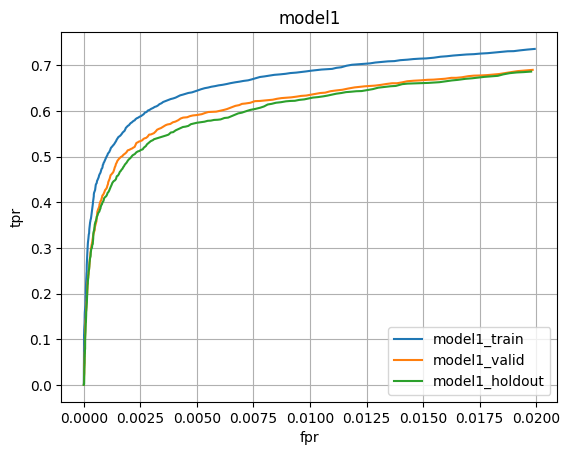

In [ ]:
plt.plot(roc_dict["model1_train"][0][roc_dict["model1_train"][0]<lauc_threshold], roc_dict["model1_train"][1][roc_dict["model1_train"][0]<lauc_threshold], label="model1_train")
plt.plot(roc_dict["model1_valid"][0][roc_dict["model1_valid"][0]<lauc_threshold], roc_dict["model1_valid"][1][roc_dict["model1_valid"][0]<lauc_threshold], label="model1_valid")
plt.plot(roc_dict["model1_holdout"][0][roc_dict["model1_holdout"][0]<lauc_threshold], roc_dict["model1_holdout"][1][roc_dict["model1_holdout"][0]<lauc_threshold], label="model1_holdout")
plt.grid()
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("model1")

Text(0.5, 1.0, 'model2')

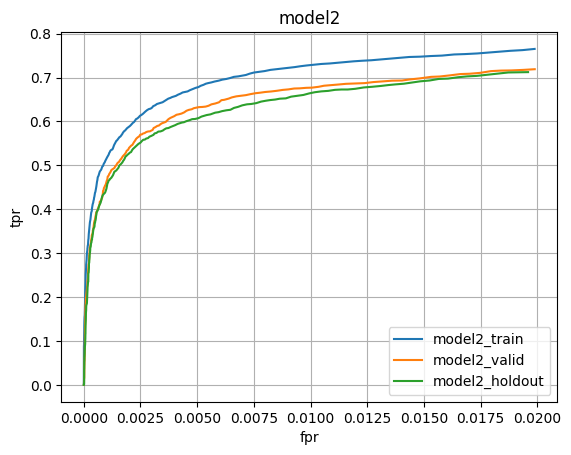

In [ ]:
plt.plot(roc_dict["model2_train"][0][roc_dict["model2_train"][0]<lauc_threshold], roc_dict["model2_train"][1][roc_dict["model2_train"][0]<lauc_threshold], label="model2_train")
plt.plot(roc_dict["model2_valid"][0][roc_dict["model2_valid"][0]<lauc_threshold], roc_dict["model2_valid"][1][roc_dict["model2_valid"][0]<lauc_threshold], label="model2_valid")
plt.plot(roc_dict["model2_holdout"][0][roc_dict["model2_holdout"][0]<lauc_threshold], roc_dict["model2_holdout"][1][roc_dict["model2_holdout"][0]<lauc_threshold], label="model2_holdout")
plt.grid()
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("model2")

Text(0.5, 1.0, 'model3')

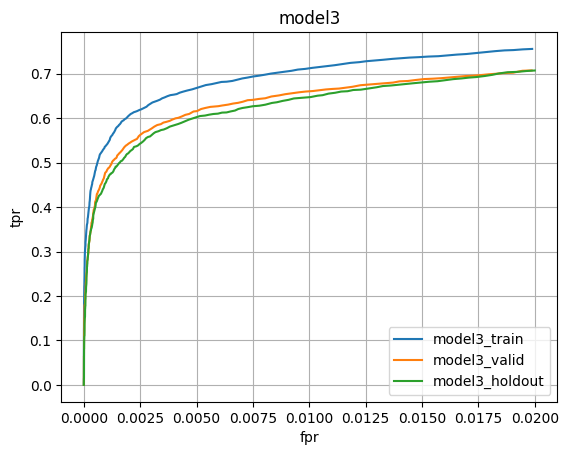

In [ ]:
plt.plot(roc_dict["model3_train"][0][roc_dict["model3_train"][0]<lauc_threshold], roc_dict["model3_train"][1][roc_dict["model3_train"][0]<lauc_threshold], label="model3_train")
plt.plot(roc_dict["model3_valid"][0][roc_dict["model3_valid"][0]<lauc_threshold], roc_dict["model3_valid"][1][roc_dict["model3_valid"][0]<lauc_threshold], label="model3_valid")
plt.plot(roc_dict["model3_holdout"][0][roc_dict["model3_holdout"][0]<lauc_threshold], roc_dict["model3_holdout"][1][roc_dict["model3_holdout"][0]<lauc_threshold], label="model3_holdout")
plt.grid()
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("model3")

In [ ]:
# Bonus To Do: If you have done more manual searches than 3, update code accordingly with your selected models to plot the roc curves

The criteria for overfitting check are quite empirical. It is normal for training performance to be better than validation or holdout performance, but not by a lot. As we learned in the previous section, validation performance is used to pick the model with the best hyper-parameters, and therefore the performance of the model selected with validation set is a little biased in favor of this data. Thus we should use a holdout set to do a fair performance evaluation. In general, training performance metrics should be better than both validation and holdout. The validation performance of the model selected accordingly should be a little better than but very similar to the holdout. If you see a model that greatly deviates from these general criteria, you need to be careful before using this model as the final one. If the holdout set is not available, then the best you can do is to (1) just use the validation set or (2) further split the validation set to form the holdout set. Holdout set is not mandatory for training model and is just used for a fair evaluation of the model performance.


Using the following results as example:

Model 1:
* train AUC: 0.9857322, train LAUC: 0.9340632
* valid AUC: 0.9849141, valid LAUC: 0.9283791
* holdout AUC: 0.9806905, holdout LAUC: 0.9194810

Model 2:
* train AUC: 0.9865086, train LAUC: 0.9406214
* valid AUC: 0.9863083, valid LAUC: 0.9353943
* holdout AUC: 0.9816900, holdout LAUC: 0.9262757

Model 3:
* train AUC: 0.9880360, train LAUC: 0.9474735
* valid AUC: 0.9875406, valid LAUC: 0.9420077
* holdout AUC: 0.9829072, holdout LAUC: 0.9325904

We mainly use LAUC as our criteria, but also keep an eye on AUC. For model 1, training LAUC is 0.006 better than validation LAUC; for model 2, it is 0.005; for model 3, it is 0.005. So they all look reasonable (about 0.5% difference), and don't show overfitting. If you see this number like 0.05 for a model, then you should be cautious that the model might be overfitting. Also by checking AUC, we see the differences are small as well. From the holdout set, we see that the AUC and LAUC metrics are not that different as well. So we pick the one with the best validation performance, which is model 3.  Model 3 is the best in terms of both AUC and LAUC, and doesn't have an overfitting problem.

In [ ]:
# To Do: Observe if there is significant overfitting and decide which model to pick

Do the final check of the selected model with full perf metrics


In [ ]:
# Getting a range of threshold scores
threshold_list = list(range(0,980, 5))
threshold_list.extend(range(980, 1000, 1))

# Removing any duplicated and sorting list
threshold_list = sorted(set(threshold_list))
# print(threshold_list)

In [ ]:
def calcMetrics(df1, score_col_name, threshold_list):
    pNF_f = [] # Percent Non-Fraud, %NF, measures False Positive (FP) at transaction level
    TDR_f = [] # Transaction Detection Rate (TDR, %F)
    TVDR_f = [] # Transaction Value Detection Rate, % of correctly identified fraud trxs weighted by amount
    ApNF_f = [] # Account Percent Non-Fraud, measures False Positive (FP) at account level
    ADR_f = [] # Account Detection Rate (ADR), % of correctly identified fraud accounts
    AFPR_f = [] # Account False-Positive Ratio
    RTVDR_f = [] # Real-Time Value Detection Rate
    RR_f = [] # Review Rate, Total # of Accounts with score >= Score Threshold divided by Total # of Accounts

    # count of fraud and non-fraud accounts
    accnNF_count = df1[df1['mdlIsFraudAcct'] == 0]['pan'].nunique() # Number of unique non-fraud accounts
    accnF_count = df1[df1['mdlIsFraudAcct'] == 1]['pan'].nunique() # Number of unique fraud accounts

    # count of fraud and non-fraud transactions
    trxNF_count = len(df1[df1['mdlIsFraudTrx'] == 0]) # number of non-fraud transactions
    trxF_count = len(df1[df1['mdlIsFraudTrx'] == 1]) # number of fraud transactions

    # Average fraud transaction amount of given dataset (account and transaction level)
    accnF_sum = df1.loc[(df1['mdlIsFraudAcct'] == 1) & (df1['mdlIsFraudTrx'] == 1), 'transactionAmount'].sum()
    trxAmtF = df1.loc[df1['mdlIsFraudTrx'] == 1, 'transactionAmount'].sum()

    for threshold in threshold_list:
        # Datafram with records greater than threshold
        threshold_df = df1[df1[score_col_name] >= threshold ].copy()

        # Sort filtered data
        threshold_df = threshold_df.sort_values(by=['pan','transactionDateTime'])#.reset_index(drop=True, inplace=True)

        # Non-Fraud count >= threshold for account and transaction
        accnNF_thrsh = threshold_df[threshold_df['mdlIsFraudAcct'] == 0]['pan'].nunique() # Number of non-fraud accounts scored >= threshold
        trxNF_thrsh = len(threshold_df[threshold_df['mdlIsFraudTrx'] == 0]) # Number of non-fraud transactions scored >= threshold

        # Fraud count >= threshold for account and transaction
        accnF_thrsh = threshold_df[threshold_df['mdlIsFraudAcct'] == 1]['pan'].nunique() # Number of fraud accounts scored >= threshold
        trxF_thrsh = len(threshold_df[threshold_df['mdlIsFraudTrx'] == 1]) # Number of fraud transactions scored >= threshold

        # Transaction sum of fraud accounts >= threshold and total Transaction sum of fraud account
        accnF_thrsh_sum = threshold_df.loc[(threshold_df['mdlIsFraudAcct'] == 1) & (threshold_df['mdlIsFraudTrx'] == 1), 'transactionAmount'].sum()

        # $ amount of fraud transactions scored >= threshold and all fraud transactions
        trxAmtF_thrsh = threshold_df.loc[threshold_df['mdlIsFraudTrx'] == 1, 'transactionAmount'].sum()

        # ApNF and AFPR
        # Identify False Positive via new binary column
        threshold_df.loc[:,'isFalsePositive'] = (threshold_df['mdlIsFraudAcct'] == 0) & (threshold_df['mdlIsFraudTrx'] == 0)
        lastFP = {}
        accnNF_thrsh_AFPRcount = 0

        # Keeping track of processed accounts
        processed_accounts = set()

        for index, row in threshold_df.iterrows():
            account = row['pan']
            date = row['transactionDateTime']

            if account in processed_accounts:
                continue

            if account in lastFP:
                if (date - lastFP[account]).days <= 30:
                    accnNF_thrsh_AFPRcount += 1
                    processed_accounts.add(account)
                    continue

            if row['isFalsePositive']:
                lastFP[account] = date

#         if accnF_thrsh > 0:
#             AFPRratio = (accnNF_thrsh_AFPRcount)/accnF_thrsh
#         else:
#             AFPRratio = accnNF_thrsh_AFPRcount/(accnF_thrsh+1)

        # Final Metrics
        pNF_f.append(round((trxNF_thrsh/trxNF_count)*100, 2))
        TDR_f.append(round((trxF_thrsh/trxF_count)*100, 2))
        TVDR_f.append(round((trxAmtF_thrsh/trxAmtF)*100, 2))
        ApNF_f.append(round((accnNF_thrsh_AFPRcount/accnNF_count)*100, 2))
        ADR_f.append(round((accnF_thrsh/accnF_count)*100, 2))
#         AFPR_f.append(round(AFPRratio, 2))
        RTVDR_f.append(round((accnF_thrsh_sum/accnF_sum)*100, 2))
#         RR_f.append(round((accnF_thrsh/(accnF_count + accnNF_count))*100, 2))

    return pNF_f, TDR_f, TVDR_f, ApNF_f, ADR_f, RTVDR_f
#     return pNF_f, TDR_f, TVDR_f, ApNF_f, ADR_f, AFPR_f, RTVDR_f, RR_f


In [ ]:
# Bonus To Do: calculate these metrics with the model of your selection (change the column name in the feature dataframe accordingly)
# Note: this takes a long time to run, probably > 30min.
pNF_f_train, TDR_f_train, TVDR_f_train, ApNF_f_train, ADR_f_train, RTVDR_f_train = calcMetrics(df_features_train, "score1", threshold_list)
pNF_f_valid, TDR_f_valid, TVDR_f_valid, ApNF_f_valid, ADR_f_valid, RTVDR_f_valid = calcMetrics(df_features_test, "score1", threshold_list)
pNF_f_holdout, TDR_f_holdout, TVDR_f_holdout, ApNF_f_holdout, ADR_f_holdout, RTVDR_f_holdout = calcMetrics(df_features_holdout, "score1", threshold_list)


In [ ]:
# Bonus To Do: plot those perf metrics between train, validation, and holdout set of your selected model. See if there is a huge discrepancy and thus overfitting is a problem.
# Hint: refer to week 7 where you did all these plots.

In [ ]:
# To Do: Do necessary wrap-ups like saving scores, models, and scale file. Please refer to week 6.